In [1]:
!pip install plotly==5.14.1
!pip install "jupyterlab>=3" "ipywidgets>=7.6"
!pip install jupyter-dash
!pip install -U kaleido

In [1]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing

In [2]:
excel_path = r"../../static/mock/titanium sols.xlsx"
artifacts_path = r"../../static/mock/soles_artifacts/second_dataset/"

In [3]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df = tables_dict["Table2"]['dataframe']
df = df.fillna(value=0)


worksheet name: Sheet1
tables in worksheet: 0

worksheet name: Experiment_data
tables in worksheet: 1
table name: Table1

worksheet name: Experiment_data_2
tables in worksheet: 1
table name: Table2

worksheet name: Experiment_data_3
tables in worksheet: 1
table name: Table3


In [4]:
df.shape

(76, 9)

In [5]:
df.head()

,Composition mixtures,"t, °С","t, min","с(acid), M","с(Ti4+), M",ultrasound,"d, nm","Contents, %","Stability of sols, days"
0,H2O + HNO3 + TiIPO + ButOH,45,60,4.0,0.50,0.0,618.500,100.0,16.0
1,H2O + HNO3 + TiIPO + ButOH,80,10,4.0,0.50,0.0,978.100,100.0,16.0
2,H2O + HNO3 + TiIPO + ButOH,45,20,4.0,0.50,0.0,2.000,100.0,90.0
3,H2O + HNO3 + TiIPO + ButOH,45,20,4.0,0.47,0.0,2.628,100.0,60.0
4,H2O + HNO3 + TiIPO + IPOОН,50,20,4.0,0.20,0.0,1712.000,100.0,16.0


In [6]:
df.drop('Composition mixtures', axis=1).astype('float').describe().T

,count,mean,std,min,25%,50%,75%,max
"t, °С",76.0,61.592105,19.864996,20.00,45.000,70.0000,80.00,93.00
"t, min",76.0,31.236842,30.303737,8.00,11.000,13.5000,58.50,130.00
"с(acid), M",76.0,1.004737,1.493205,0.10,0.100,0.1000,1.58,4.00
"с(Ti4+), M",76.0,0.425526,0.191154,0.14,0.200,0.5000,0.60,0.62
ultrasound,76.0,0.157895,0.401751,0.00,0.000,0.0000,0.00,1.50
"d, nm",76.0,666.301395,924.147741,0.70,2.028,2.6955,2000.00,3096.00
"Contents, %",76.0,97.226316,13.895729,0.50,100.000,100.0000,100.00,100.00
"Stability of sols, days",76.0,24.657895,23.828864,0.00,2.000,16.0000,40.00,90.00


In [7]:
composition_mixtures_dict = {
    'H2O + HNO3 + TiIPO + ButOH': 1,
    'H2O + HNO3 + TiIPO + IPOОН': 2,
    'H2O + HNO3 + ТiBut + ButOH': 3,
    'H2O + TiOSO₄´xH2SO4´yH2O': 4,
}
df = df.replace(composition_mixtures_dict)

/var/folders/03/8g_v72pd32vfbhfq91cfy1780000gn/T/ipykernel_25986/2365379211.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(composition_mixtures_dict)


In [8]:
df.dtypes

Composition mixtures         int64
t, °С                        int64
t, min                       int64
с(acid), M                 float64
с(Ti4+), M                 float64
ultrasound                 float64
d, nm                      float64
Contents, %                float64
Stability of sols, days    float64
dtype: object

In [9]:
X = df.drop(['Composition mixtures', 'Contents, %', 'd, nm', 'Stability of sols, days', 'ultrasound '], axis=1)
y_days = df['Stability of sols, days']
y_d = df['d, nm']
y_content = df['Contents, %']

In [10]:
X

,"t, °С","t, min","с(acid), M","с(Ti4+), M"
0,45,60,4.0,0.50
1,80,10,4.0,0.50
2,45,20,4.0,0.50
3,45,20,4.0,0.47
4,50,20,4.0,0.20
...,...,...,...,...
71,70,12,0.1,0.62
72,70,12,0.1,0.59
73,70,12,0.1,0.55
74,70,12,0.1,0.52


# Linear regression for coafitionts predictions

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
clf.fit(X, y_days)
best_linear_regression_days = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_days.coef_)

-14.582918599976136
{'fit_intercept': False}
[-0.16239344 -0.14348742  5.17165432 79.93796575]


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X, y_d)
best_linear_regression_d = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_d.coef_)

-368.24754555121774
{'fit_intercept': True}
[  20.51977907 -280.85882185 -114.71075337 -954.93848214]


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

parameters = {'fit_intercept': [True, False]}

model = LinearRegression()
clf = GridSearchCV(
    model, 
    parameters, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1)
clf.fit(X, y_content)
best_linear_regression_content = clf.best_estimator_
print(clf.best_score_)
print(clf.best_params_)
print(best_linear_regression_content.coef_)

-7.034565659695543
{'fit_intercept': True}
[ -0.14796999  -0.25009727  -2.29404887 -12.32332723]


# Optimisation with NSGA2 algorithm

In [15]:
!pip install -U pymoo

In [16]:
-np.append(best_linear_regression_days.coef_, best_linear_regression_days.intercept_)

array([  0.16239344,   0.14348742,  -5.17165432, -79.93796575,
        -0.        ])

In [19]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter


class SoleProblem(ElementwiseProblem):
    def __init__(self, coefs):
        self.coefs = coefs
        super().__init__(n_var=4, n_obj=3, n_ieq_constr=4,
                         xl=np.array([20, 1, 0.1, 0.14]),
                         xu=np.array([80, 130, 5, 1.5]) )

    def _evaluate(self, x, out, *args, **kwargs):
        fs = []
        gs = []
        for coef in self.coefs:
            f = coef[-1]
            for i in range(0, len(coef) - 1):
                f += x[i] * coef[i]    
            fs.append(f)
        out["F"] = fs
        out["G"] = [fs[0], -fs[1] + 0.7, fs[2], -fs[2] - 100]


problem = SoleProblem(
    [-np.append(best_linear_regression_days.coef_, best_linear_regression_days.intercept_),
     np.append(best_linear_regression_d.coef_, best_linear_regression_d.intercept_),
     -np.append(best_linear_regression_content.coef_, best_linear_regression_content.intercept_)
    ])

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ("n_gen", 500),
               verbose=False,
               seed=1)

In [21]:
import plotly.express as px
F = res.F
fig = px.scatter(x=-F[:, 0], y=F[:, 1], labels={"x": "Stability of sols, days", "y": "d, nm"})
fig.write_html(artifacts_path + 'first_figure.html', auto_open=True)
fig.write_image(artifacts_path + 'optimal.png')

In [20]:
for f, x in zip(res.F, res.X):
    print(f'For getting stability days = {round(-f[0], 3)}, diameter = {round(f[1], 3)} and content = {round(-f[2], 3)} use:')
    print(f'\ttemperature = {round(x[0], 3)}')
    print(f'\ttime = {round(x[1], 3)}')
    print(f'\tc(acid) = {round(x[2], 3)}')
    print(f'\tc(Ti) = {round(x[3], 3)}')

For getting stability days = 69.911, diameter = 137.571 and content = 100.0 use:
	temperature = 56.483
	time = 2.573
	c(acid) = 0.302
	c(Ti) = 0.974
For getting stability days = 132.791, diameter = 0.716 and content = 79.805 use:
	temperature = 79.009
	time = 1.0
	c(acid) = 5.0
	c(Ti) = 1.5
For getting stability days = 84.305, diameter = 256.551 and content = 100.0 use:
	temperature = 47.741
	time = 1.004
	c(acid) = 0.115
	c(Ti) = 1.146
For getting stability days = 132.791, diameter = 0.714 and content = 79.805 use:
	temperature = 79.009
	time = 1.0
	c(acid) = 5.0
	c(Ti) = 1.5
For getting stability days = 84.317, diameter = 257.44 and content = 100.0 use:
	temperature = 47.741
	time = 1.0
	c(acid) = 0.114
	c(Ti) = 1.146
For getting stability days = 109.706, diameter = 0.701 and content = 95.515 use:
	temperature = 51.062
	time = 1.056
	c(acid) = 0.102
	c(Ti) = 1.471
For getting stability days = 83.743, diameter = 203.376 and content = 100.0 use:
	temperature = 47.613
	time = 1.2
	c(aci

# Random forest feature importance prediction

In [22]:
!pip install xgboost

In [11]:
X = df.drop(['Contents, %', 'd, nm', 'Stability of sols, days', 'ultrasound '], axis=1)
y_days = df['Stability of sols, days']
y_d = df['d, nm']
y_content = df['Contents, %']

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 

In [13]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


In [41]:
from matplotlib.offsetbox import AnchoredText

def draw_importance(importances, model_name, columns=X.columns, ax=None):
    features = {}
    color1 = "#2D466D"
    color2 = "#A2B0C5"
    for i, feature in enumerate(columns):
        features[f"f{i+1}"] = feature

    indices = np.argsort(importances)[::-1]
    num_to_plot = len(columns)
    feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

    print("Feature ranking:")
    for f in range(num_to_plot):
        print(
            "%d. %s %f "
            % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
        )
    is_save = False
    if ax is None:
        plt.figure(figsize=(20, 10))
        ax = plt
        is_save = True

    bars = ax.bar(
        range(num_to_plot),
        importances[indices[:num_to_plot]],
        color=get_color_gradient(color1, color2, num_to_plot),
        align="center",
    )
    ax.set_xticks(range(num_to_plot), feature_indices)
    ax.set_xlim([-1, num_to_plot])
    ax.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices], fontsize=16)
    # ax.set_title(f"Feature importance in {model_name}", fontsize=18)
    txt = AnchoredText(model_name, loc="lower right", pad=0.25, borderpad=0, prop=dict(fontsize="xx-large"))
    ax.add_artist(txt)
    ax.tick_params(axis='both', labelsize=16)
    if is_save:
        plt.savefig(f'{artifacts_path}{model_name}.png', format='png', dpi=600, bbox_inches='tight', transparent="True", pad_inches=0)
    

In [42]:
def draw_random_forest(X, y, name, ax=None):
    parameters = {
        'n_estimators': range(100, 500, 100),
        'max_depth': [None] + list(range(3, 11, 2))}

    model = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_random_forest = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_random_forest.feature_importances_, f"a", ax=ax)

In [43]:
def draw_gradient_boosting(X, y, name, ax=None):
    parameters = {
        'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': [4, 8, 16, 32, 64, 128],
        'max_depth': range(1, 18, 2)}

    model = GradientBoostingRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_gradient_boost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_gradient_boost.feature_importances_, f"b", ax=ax)

In [44]:
def draw_xgboost(X, y, name, ax=None):
    parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5,],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_xgboost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_xgboost.feature_importances_, f"c", ax=ax)

## Stability days

-9.874668055555556
{'max_depth': None, 'n_estimators': 100}
Feature ranking:
1. с(Ti4+), M 0.470774 
2. t, min 0.223826 
3. t, °С 0.200095 
4. с(acid), M 0.072943 
5. Composition mixtures 0.032362 
-9.363332044592362
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 8}
Feature ranking:
1. t, min 0.573710 
2. с(acid), M 0.190699 
3. с(Ti4+), M 0.121620 
4. t, °С 0.099190 
5. Composition mixtures 0.014782 
-9.174310174733401
{'colsample_bytree': 1.0, 'gamma': 2.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}
Feature ranking:
1. с(Ti4+), M 0.362655 
2. t, min 0.276932 
3. с(acid), M 0.193746 
4. t, °С 0.092629 
5. Composition mixtures 0.074038 


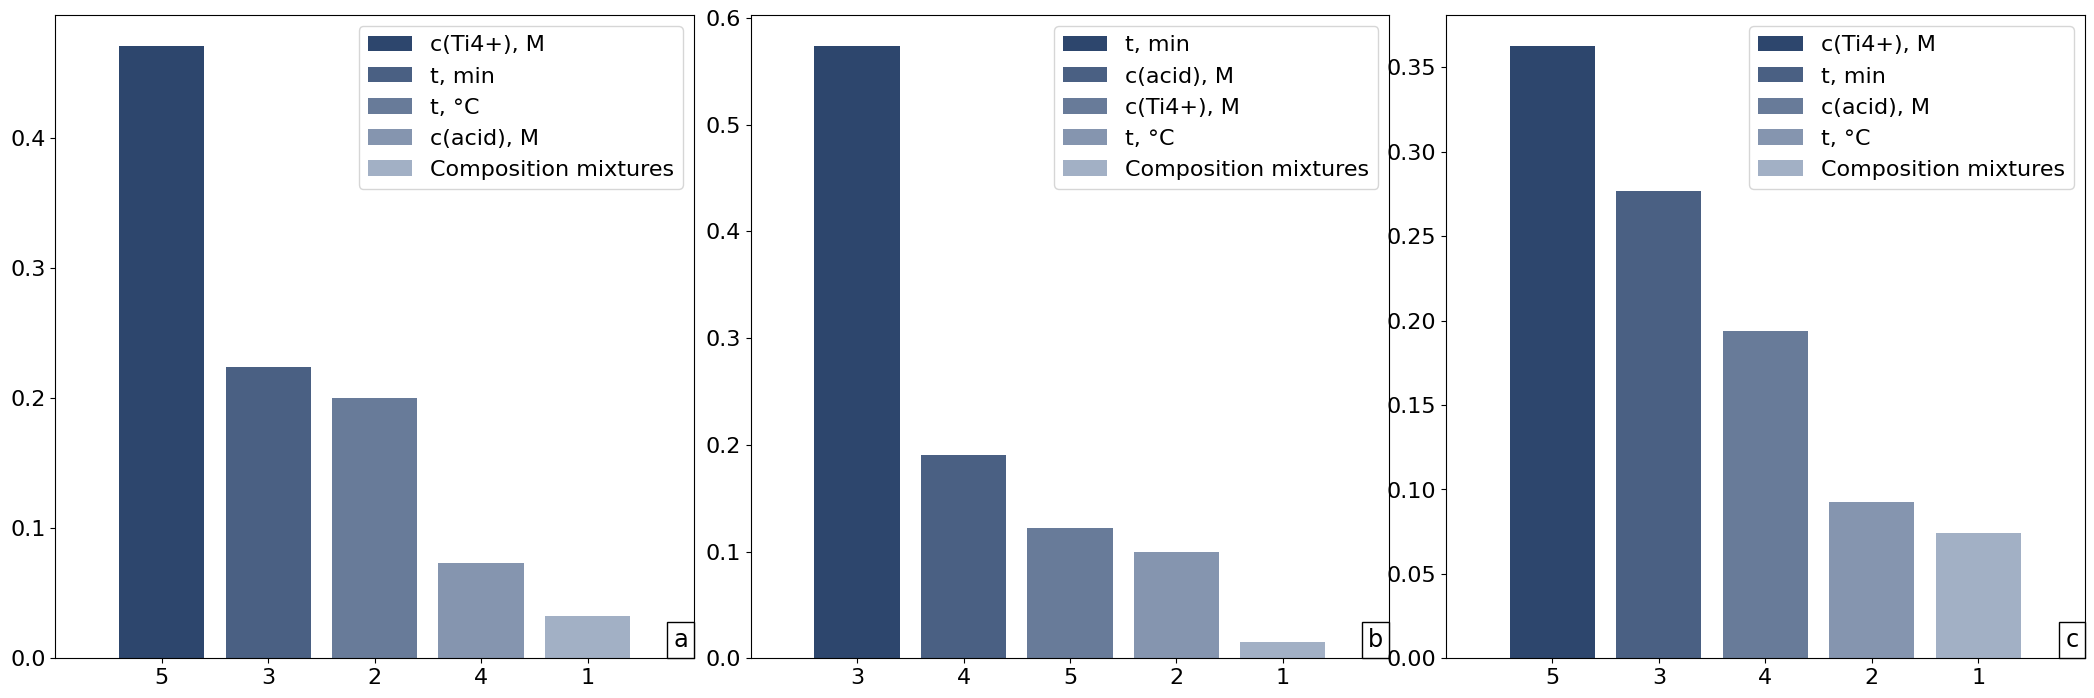

In [45]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(21, 7),
)
fig.tight_layout(pad=1.3)
draw_random_forest(X, y_days, "days of stability", ax=axes[0])
draw_gradient_boosting(X, y_days, "days of stability", ax=axes[1])
draw_xgboost(X, y_days, "days of stability", ax=axes[2])
plt.savefig(f'{artifacts_path}_StabilityDays.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0)

## Diameter

-468.39543766408843
{'max_depth': None, 'n_estimators': 100}
Feature ranking:
1. с(Ti4+), M 0.708352 
2. $\tau$, min 0.112443 
3. с(acid), M 0.078989 
4. t, °С 0.067185 
5. Composition mixtures 0.033031 
-449.68975987327246
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 4}
Feature ranking:
1. с(Ti4+), M 0.881525 
2. с(acid), M 0.079495 
3. $\tau$, min 0.038980 
4. t, °С 0.000000 
5. Composition mixtures 0.000000 
-392.7445861589034
{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}
Feature ranking:
1. с(Ti4+), M 0.476958 
2. с(acid), M 0.248387 
3. Composition mixtures 0.158683 
4. $\tau$, min 0.063510 
5. t, °С 0.052463 


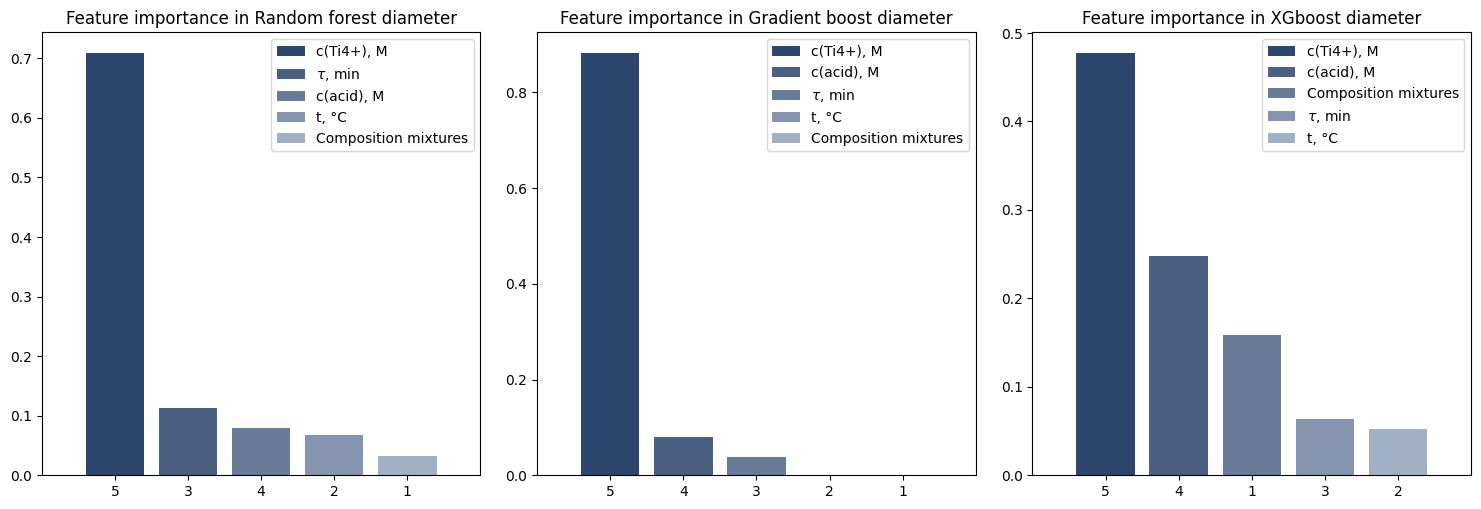

In [78]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(15, 5),
)
fig.tight_layout(pad=1)
draw_random_forest(X, y_d, "diameter", ax=axes[0])
draw_gradient_boosting(X, y_d, "diameter", ax=axes[1])
draw_xgboost(X, y_d, "diameter", ax=axes[2])
plt.savefig(f'{artifacts_path}_Diameter.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0)

## Content

-5.761198256944462
{'max_depth': 7, 'n_estimators': 400}
Feature ranking:
1. $\tau$, min 0.597745 
2. Composition mixtures 0.166672 
3. с(acid), M 0.086602 
4. с(Ti4+), M 0.075967 
5. t, °С 0.073015 
-5.061069349486159
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 4}
Feature ranking:
1. $\tau$, min 0.598934 
2. Composition mixtures 0.322132 
3. с(acid), M 0.077698 
4. t, °С 0.000646 
5. с(Ti4+), M 0.000590 
-4.696343691507975
{'colsample_bytree': 0.6, 'gamma': 2, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}
Feature ranking:
1. $\tau$, min 0.280930 
2. с(Ti4+), M 0.280458 
3. Composition mixtures 0.179078 
4. с(acid), M 0.136626 
5. t, °С 0.122907 


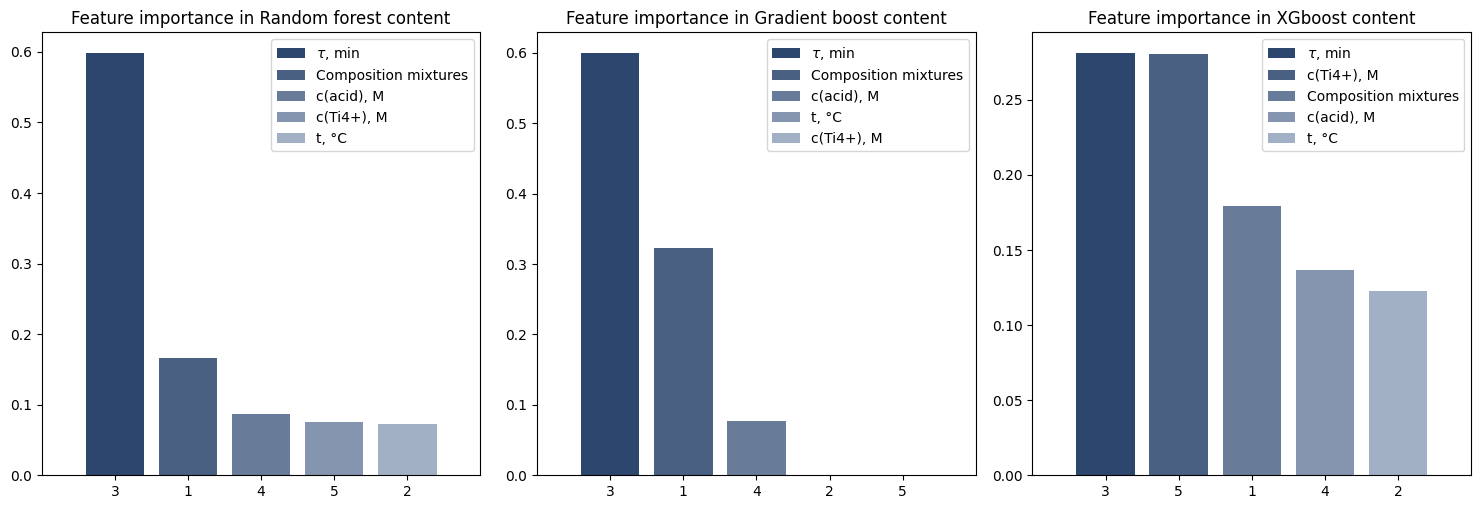

In [79]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(15, 5),
)
fig.tight_layout(pad=1)
draw_random_forest(X, y_content, "content", ax=axes[0])
draw_gradient_boosting(X, y_content, "content", ax=axes[1])
draw_xgboost(X, y_content, "content", ax=axes[2])
plt.savefig(f'{artifacts_path}_Content.png', format='png', dpi=600, bbox_inches='tight', pad_inches=0)

# Results

In [19]:
df = df.rename(columns={'t, min': r'$\tau$, min'})

In [14]:
new_col = []
for elem in df['d, nm']:
    if elem > 2000:
        new_col.append(5)
    elif elem > 1000:
        new_col.append(4)
    elif elem > 400:
        new_col.append(3)
    elif elem > 2:
        new_col.append(2)
    elif elem > 1:
        new_col.append(1)
    else:
        new_col.append(0)
df['d_categorical'] = new_col

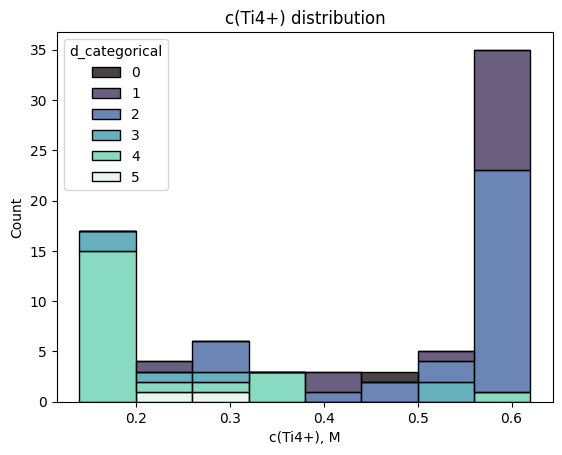

In [15]:
sns.histplot(df, x='с(Ti4+), M', hue='d_categorical', multiple="stack", palette='mako').set(title=f'с(Ti4+) distribution')
plt.savefig(artifacts_path + 'Ti4Distribution.png', format='png', dpi=600)
plt.show()

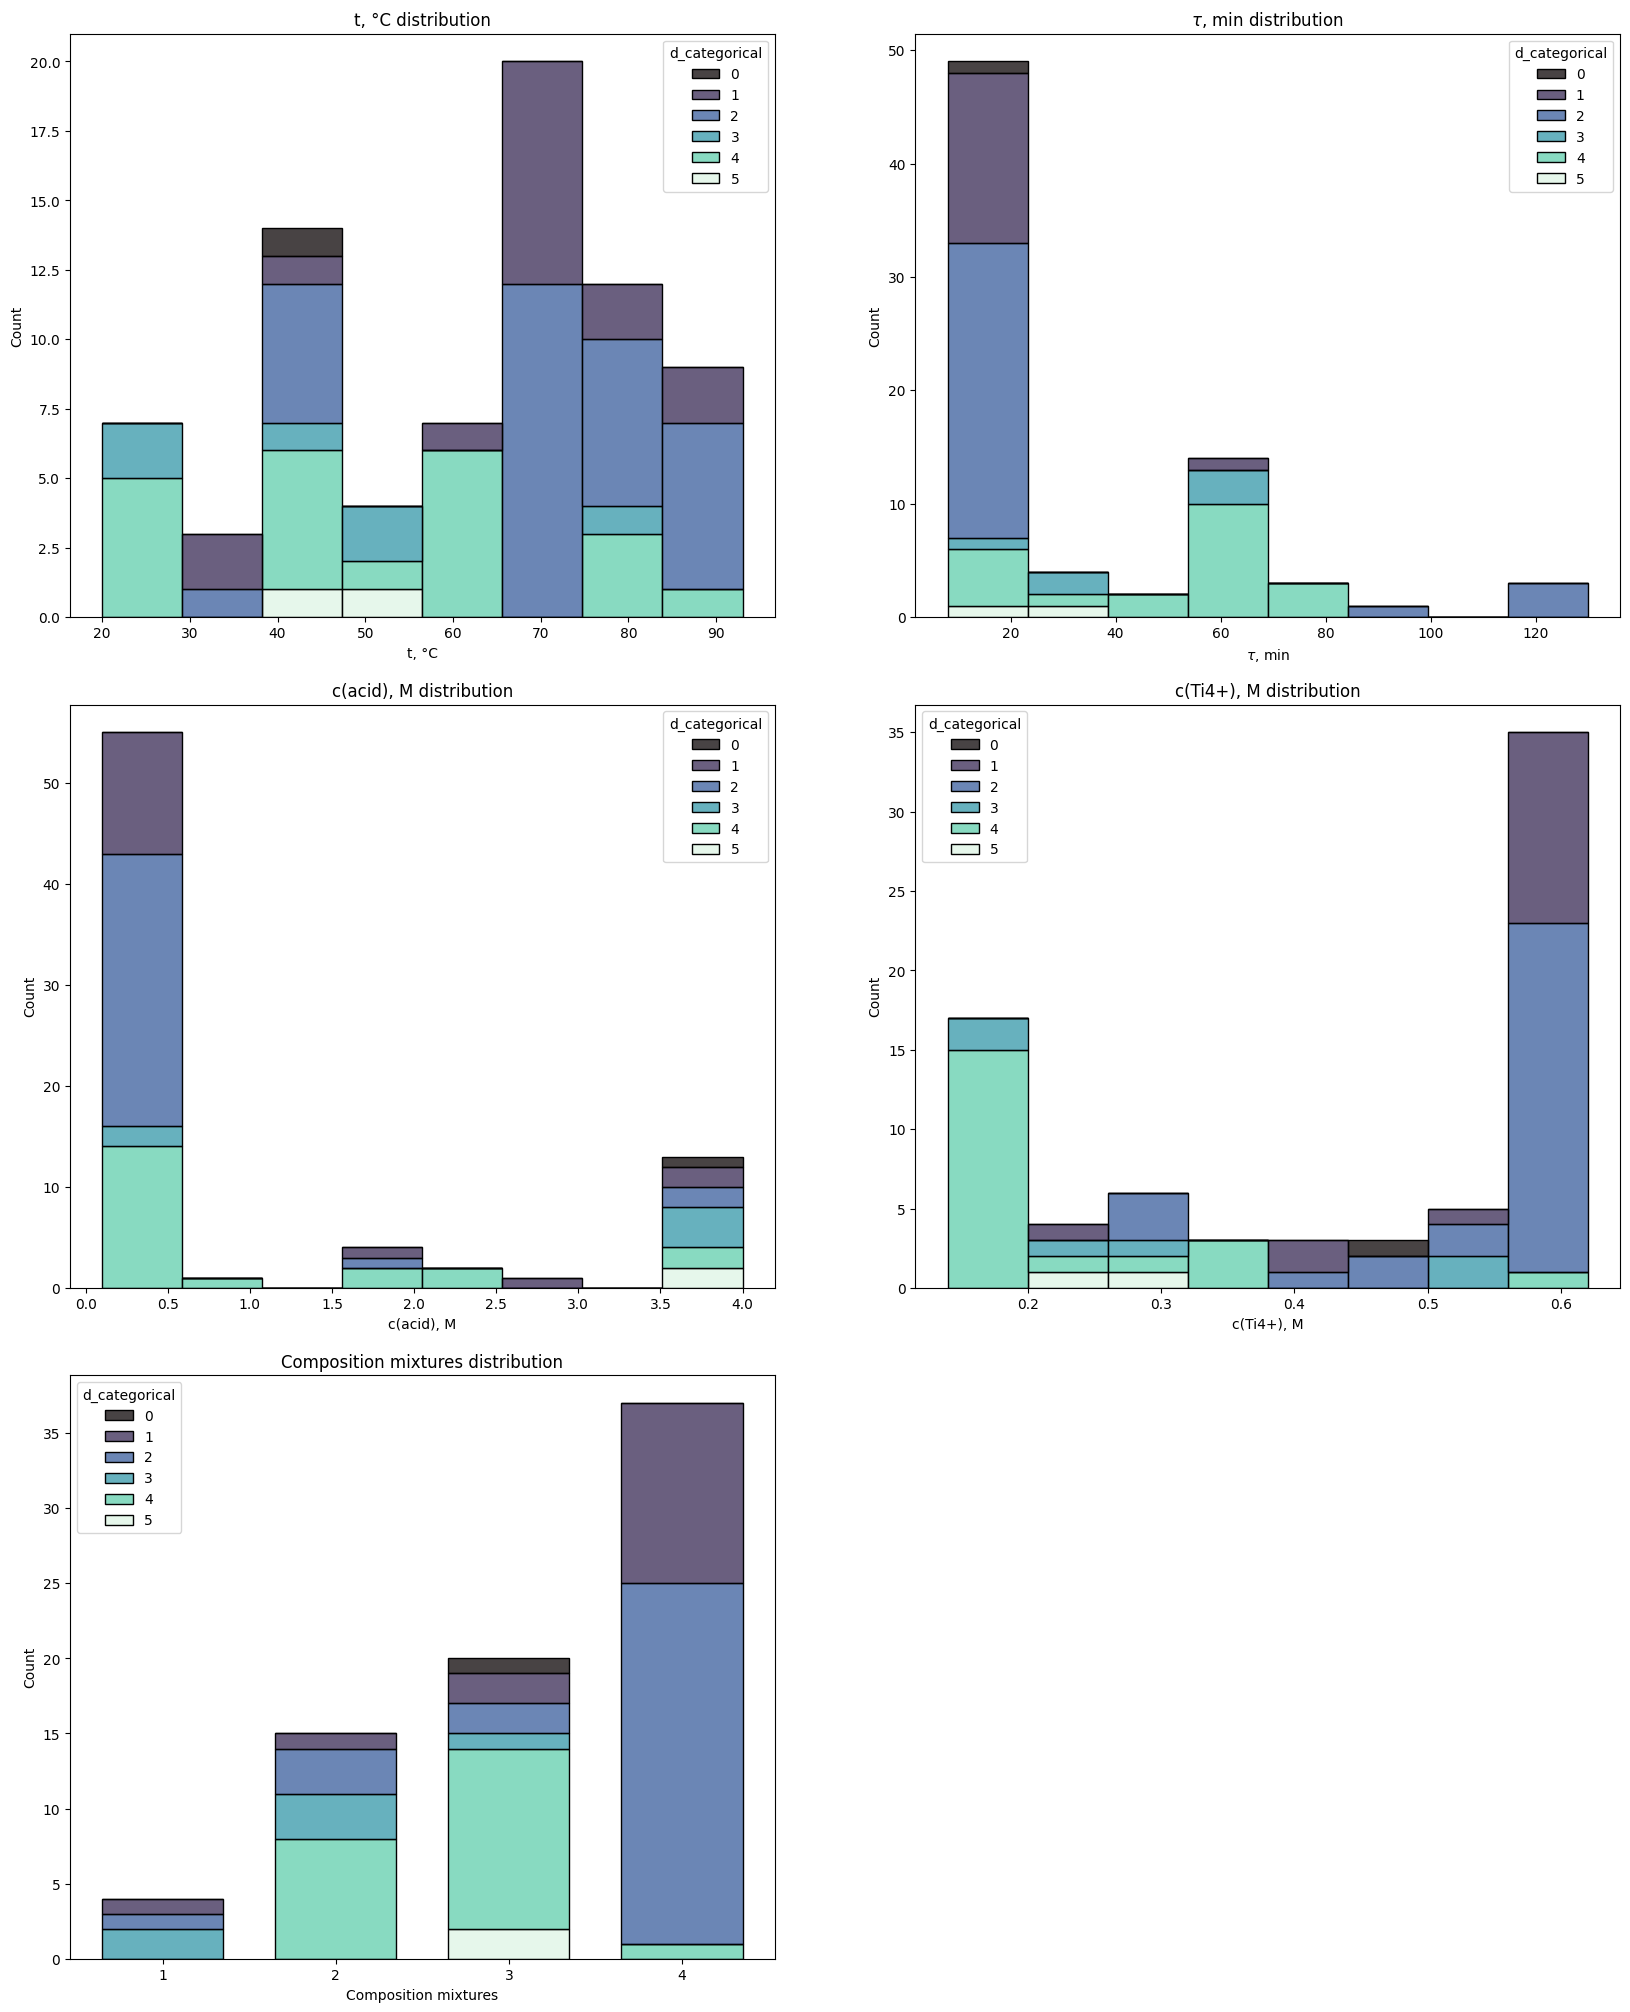

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(20, 25)

for col, ax in zip(['t, °С', r'$\tau$, min', 'с(acid), M', 'с(Ti4+), M', 'Composition mixtures'], axes.flat):
    if col == 'Composition mixtures':
        ax.set_xticks([1, 2, 3, 4])
        sns.histplot(df, x=col, hue='d_categorical', multiple="stack", palette='mako', ax=ax, discrete=True, shrink=.7).set(title=f'{col} distribution')
    else:
        sns.histplot(df, x=col, hue='d_categorical', multiple="stack", palette='mako', ax=ax).set(title=f'{col} distribution')

fig.subplots_adjust(hspace=0.15)
axes[-1, -1].axis('off')
plt.savefig(artifacts_path + 'distibution_with_d_categorical.png', format='png', dpi=600)
plt.show()

In [17]:
df_plot = df.copy(deep=True)

def replace_func_days(x):
    if x < 20:
        return "< 20"
    else:
        return str(x)

df_plot['Stability of sols, days'] = df_plot['Stability of sols, days'].apply(replace_func_days)

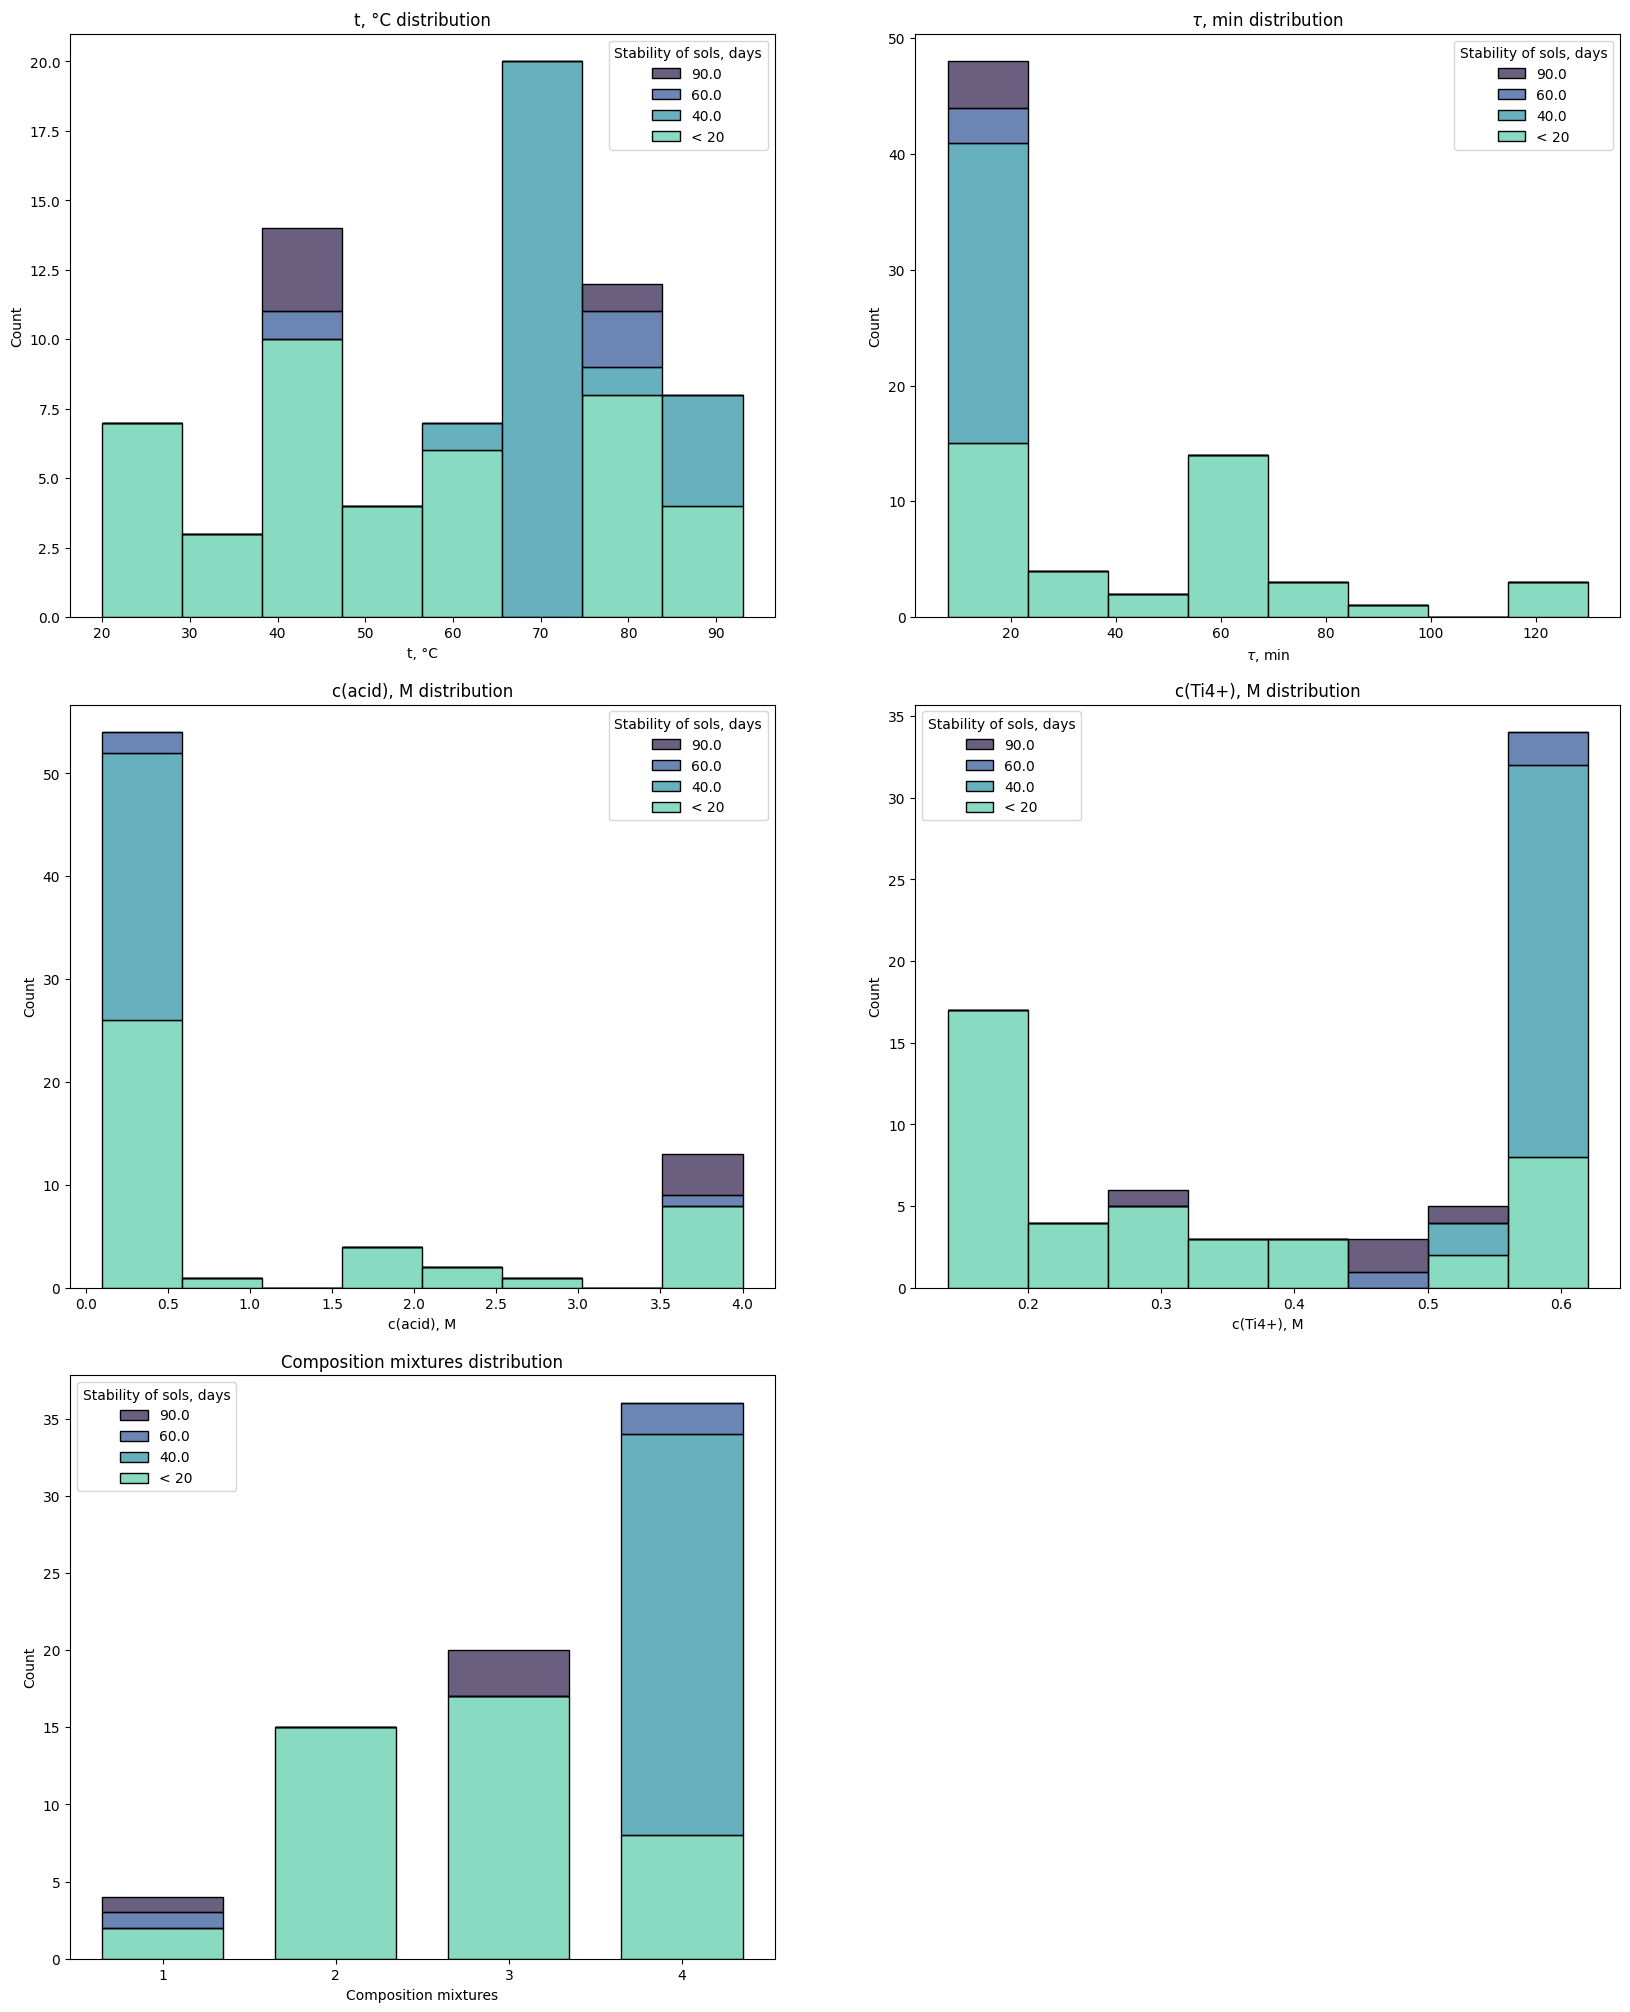

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(20, 25)

for col, ax in zip(['t, °С', r'$\tau$, min', 'с(acid), M', 'с(Ti4+), M', 'Composition mixtures'], axes.flat):
    if col == 'Composition mixtures':
        ax.set_xticks([1, 2, 3, 4])
        sns.histplot(df_plot, x=col, discrete=True, shrink=.7, hue='Stability of sols, days', hue_order =['90.0', '60.0', '40.0', '< 20'], multiple="stack", palette='mako', ax=ax).set(title=f'{col} distribution')
    else:
        sns.histplot(df_plot, x=col, hue='Stability of sols, days', hue_order =['90.0', '60.0', '40.0', '< 20'], multiple="stack", palette='mako', ax=ax).set(title=f'{col} distribution')

fig.subplots_adjust(hspace=0.15)
axes[-1, -1].axis('off')
plt.savefig(artifacts_path + 'distibution_with_stability_days.png', format='png', dpi=600)
plt.show()

In [19]:
df_plot = df.copy(deep=True)

def replace_func_days(x):
    if x < 96:
        return "< 96"
    else:
        return str(x)

df_plot['Contents, %'] = df_plot['Contents, %'].apply(replace_func_days)

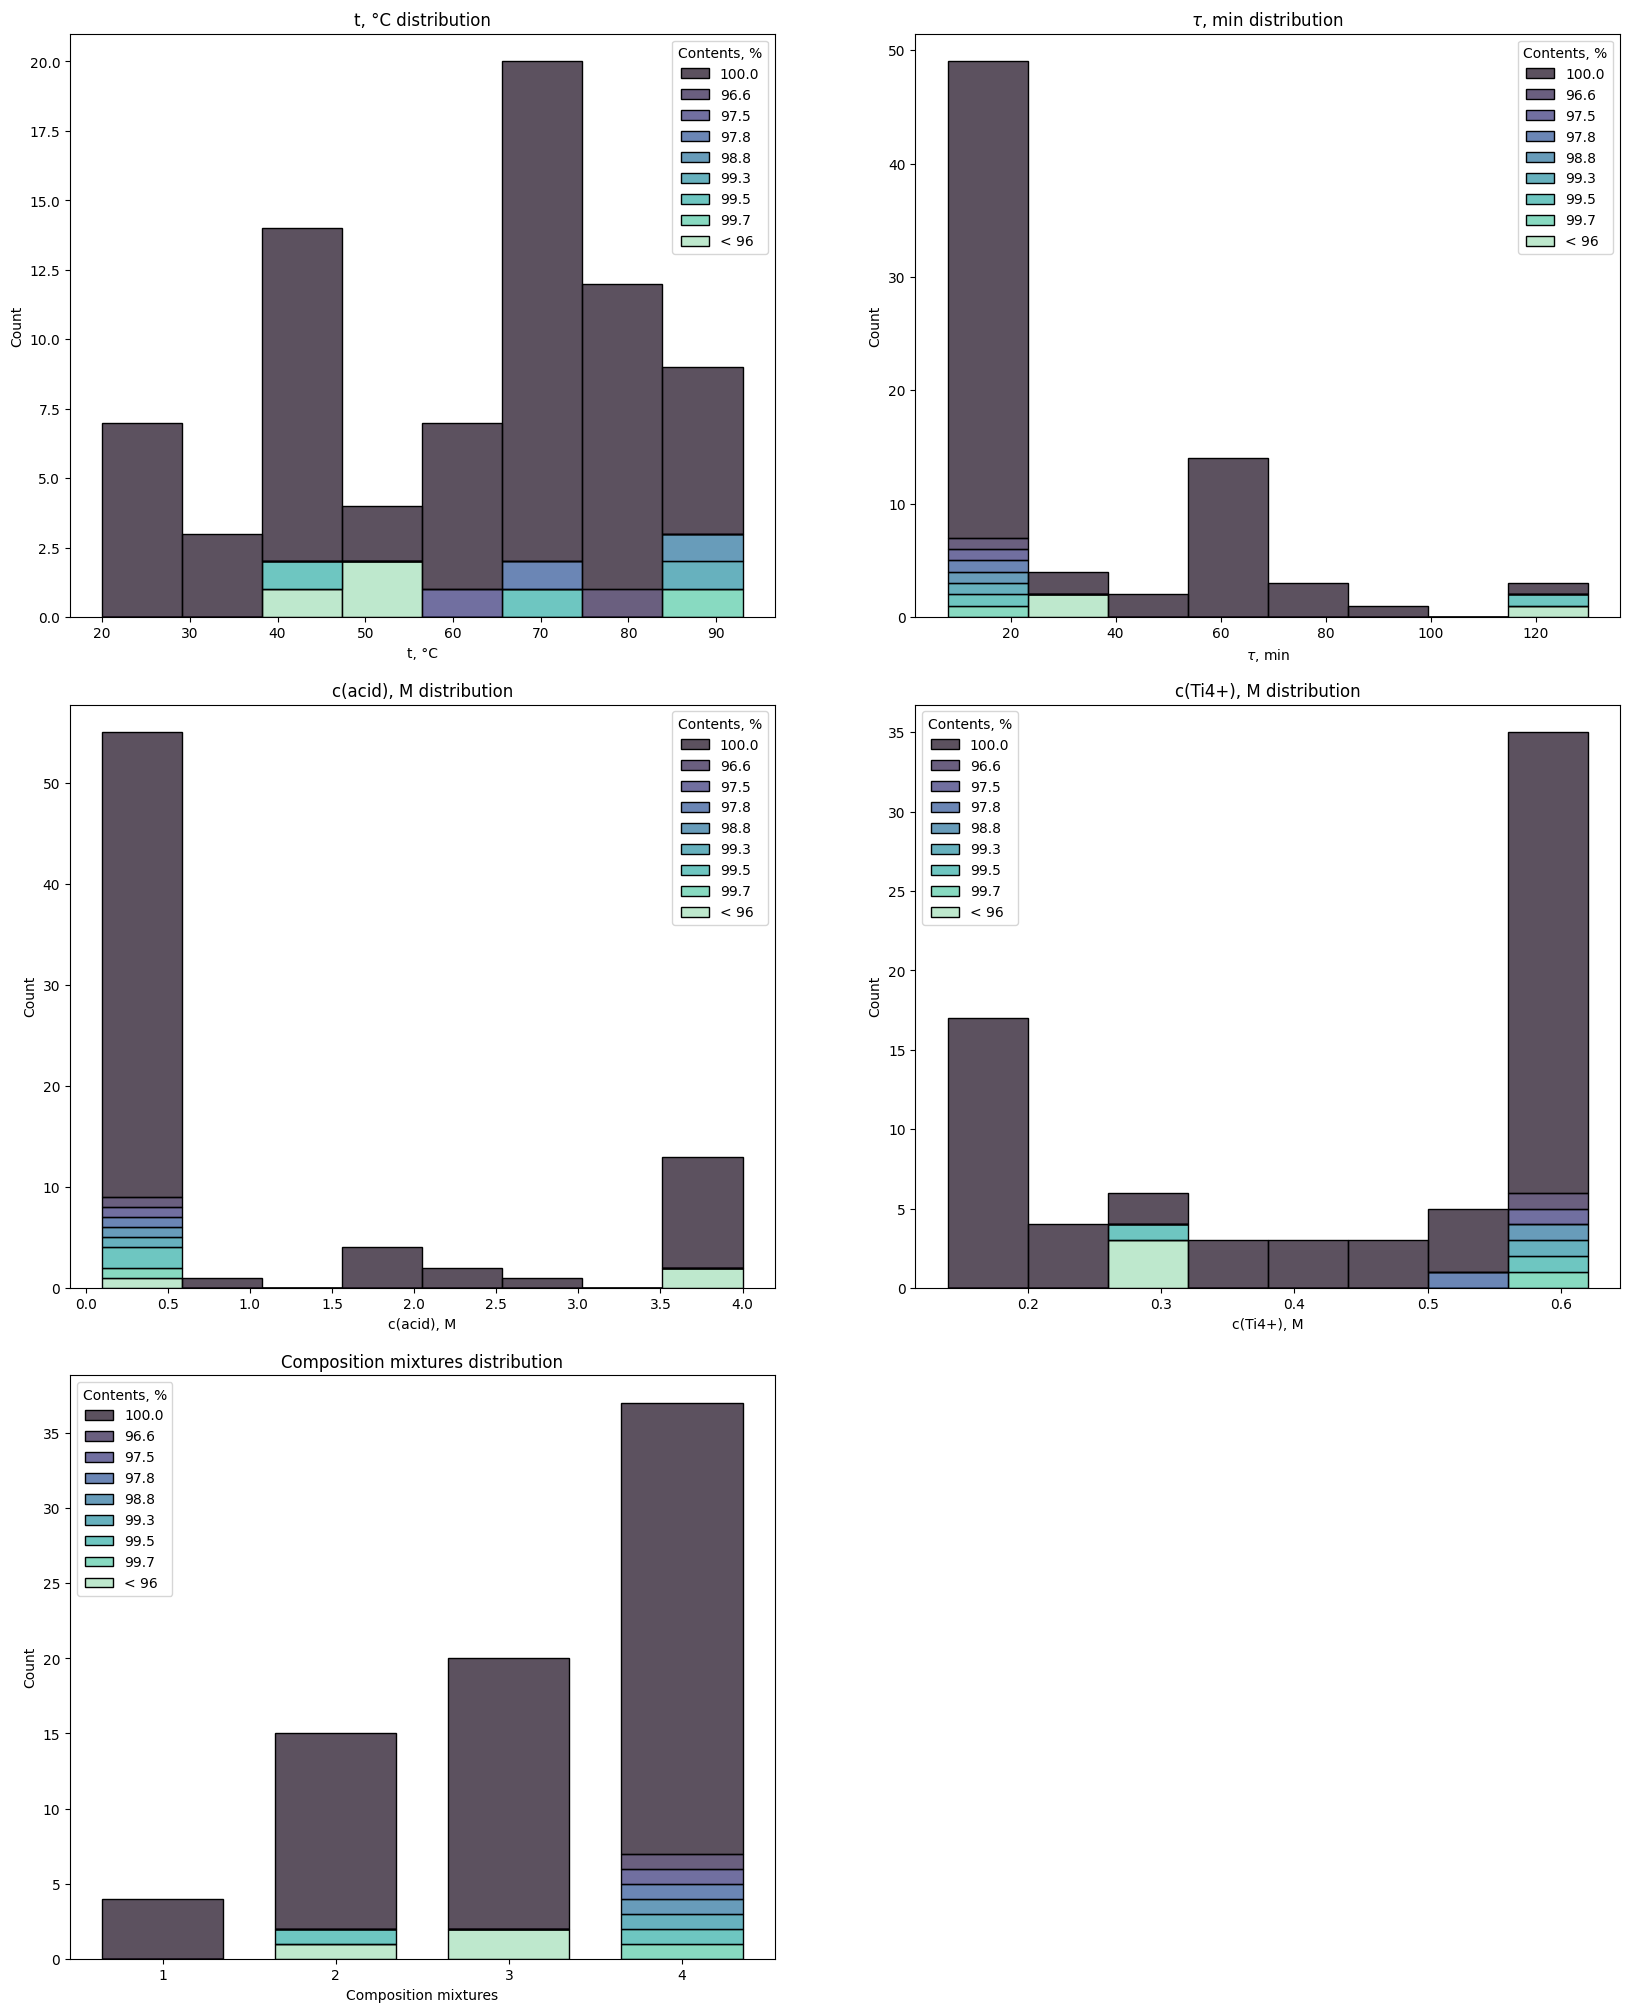

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(20, 25)

for col, ax in zip(['t, °С', r'$\tau$, min', 'с(acid), M', 'с(Ti4+), M', 'Composition mixtures'], axes.flat):
    if col == 'Composition mixtures':
        ax.set_xticks([1, 2, 3, 4])
        sns.histplot(df_plot, x=col, discrete=True, shrink=.7, hue='Contents, %', hue_order=['100.0', '96.6', '97.5', '97.8', '98.8', '99.3', '99.5', '99.7',
       '< 96'], multiple="stack", palette='mako', ax=ax).set(title=f'{col} distribution')
    else:
        sns.histplot(df_plot, x=col, hue='Contents, %', hue_order=['100.0', '96.6', '97.5', '97.8', '98.8', '99.3', '99.5', '99.7',
       '< 96'], multiple="stack", palette='mako', ax=ax).set(title=f'{col} distribution')

fig.subplots_adjust(hspace=0.15)
axes[-1, -1].axis('off')
plt.savefig(artifacts_path + 'distibution_with_contents.png', format='png', dpi=600)
plt.show()